# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** MARGOHAN L. SIRINGO-RINGO
- **Email:** gohanlabanta@gmail.com
- **ID Dicoding:** MC009D5Y2431

## Import Semua Packages/Library yang Digunakan

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Dropout, Flatten, Input, BatchNormalization, Rescaling
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt



## Data Preparation

### Data Loading

In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
         print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/intel-image-classification/seg_pred/seg_pred/20481.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/14977.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/8763.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/12099.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/21131.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/4572.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/20412.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/13620.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/10052.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/17167.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/6348.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/5645.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/389.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred

### Data Preprocessing

#### Split Dataset

In [48]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set path
base_dir = '/kaggle/input/intel-image-classification/'

train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

# Image size dan batch size
img_height, img_width = 150, 150
batch_size = 32

# Data Augmentation + Rescale untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% dari training data untuk validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Hanya rescale untuk validation dan testing
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data (80%)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data (20%)
valid_generator = valid_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [49]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


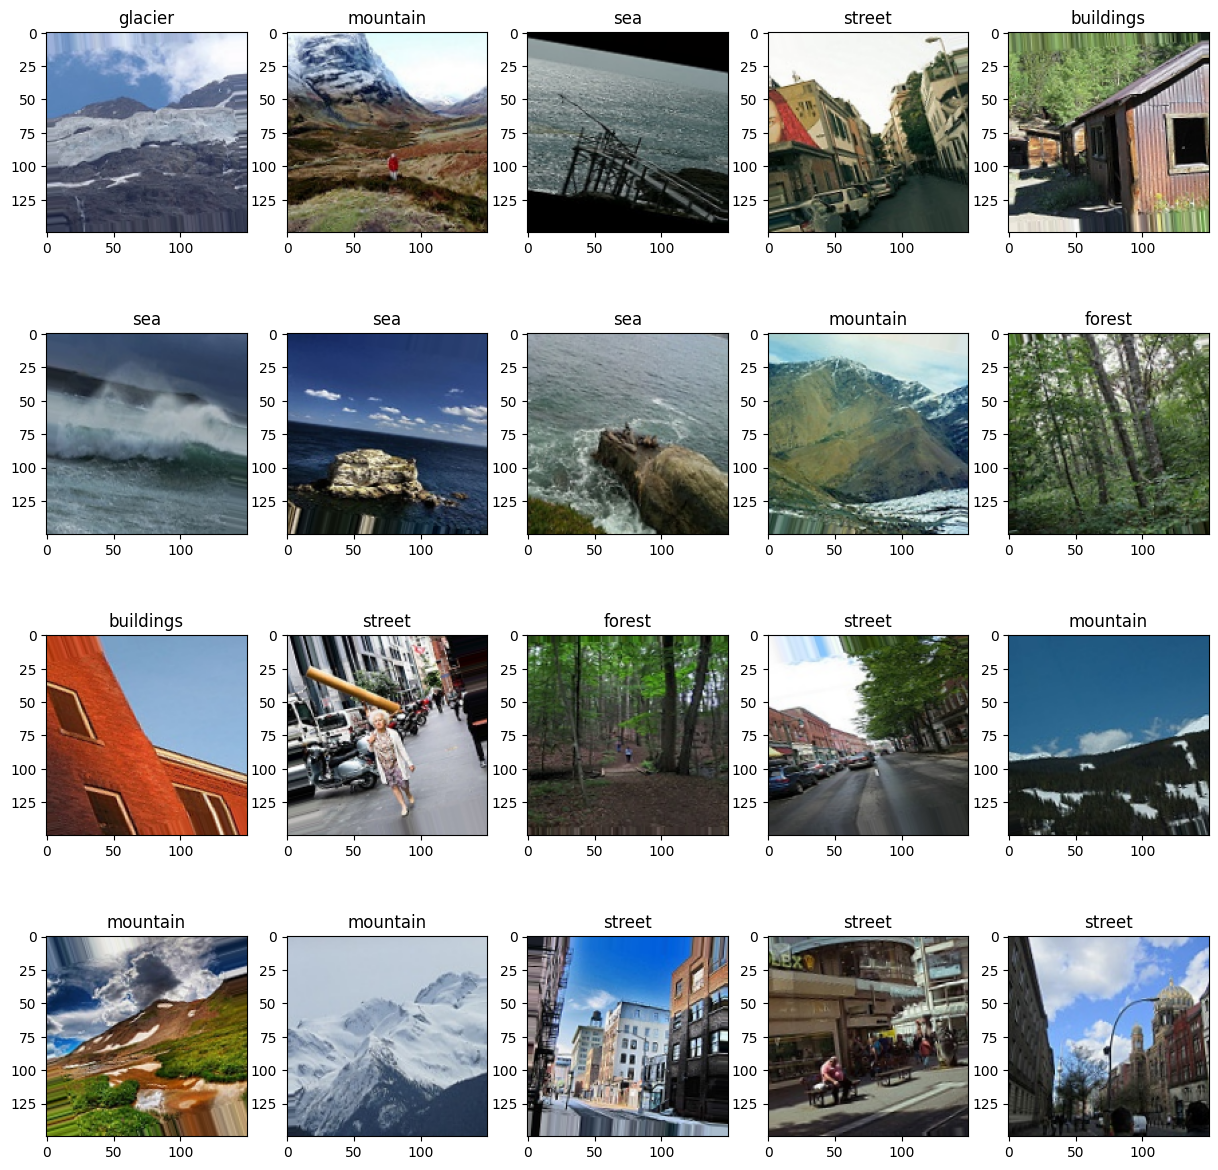

In [50]:
batch_images, batch_labels = next(train_generator)
batch_images = (batch_images * 255).astype(np.uint8)

plt.figure(figsize=(15, 15))
for i in range(20):
    img_aug = batch_images[i]
    plt.subplot(4, 5, i+1)
    class_index = np.argmax(batch_labels[i])  # Mengambil indeks kelas dari one-hot encoding

    # Mengakses nama kelas menggunakan class_indices
    class_name = list(train_generator.class_indices.keys())[class_index]
    plt.title(class_name)
    plt.imshow(img_aug)
    plt.axis("on")

plt.show()

## Modelling

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasi & test tetap hanya rescale
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator ulang (harus run ulang setelah datagen berubah)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [52]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 tanpa top layers
base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze semua layer awal
base_model.trainable = False

# Tambahkan top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  # 6 kelas

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ringkasan model
model.summary()

<ipython-input-52-2cf0699b0a52>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [53]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

# Custom Callback untuk stop jika akurasi validasi tetap di bawah 90%
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.90, patience=3):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc < self.threshold:
            self.wait += 1
            print(f"\nValidation accuracy {val_acc:.2f} masih di bawah {self.threshold}, percobaan ke-{self.wait}")
            if self.wait >= self.patience:
                print(f"\nTraining dihentikan karena akurasi validasi tidak melebihi {self.threshold} selama {self.patience} epoch.")
                self.model.stop_training = True
        else:
            self.wait = 0

# Callback lainnya
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenetv2_best_model.keras', monitor='val_accuracy', save_best_only=True)
accuracy_threshold = AccuracyThresholdCallback(threshold=0.90, patience=3)

# Training model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, accuracy_threshold]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4597 - loss: 1.4836
Validation accuracy 0.80 masih di bawah 0.9, percobaan ke-1
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 227ms/step - accuracy: 0.4601 - loss: 1.4825 - val_accuracy: 0.7989 - val_loss: 0.5605
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7361 - loss: 0.7212
Validation accuracy 0.85 masih di bawah 0.9, percobaan ke-2
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 218ms/step - accuracy: 0.7361 - loss: 0.7211 - val_accuracy: 0.8456 - val_loss: 0.4208
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7735 - loss: 0.6124
Validation accuracy 0.84 masih di bawah 0.9, percobaan ke-3

Training dihentikan karena akurasi validasi tidak melebihi 0.9 selama 3 epoch.
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7735 - loss: 0.6124 - val_accuracy: 0.8442 - val_loss: 0.3956


Kesimpulan: Akurasi yang didapatkan adalah 85%.

## Evaluasi dan Visualisasi

In [54]:
# Evaluasi model menggunakan data test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8759 - loss: 0.3218
Test Accuracy: 84.87%
Test Loss: 0.4012


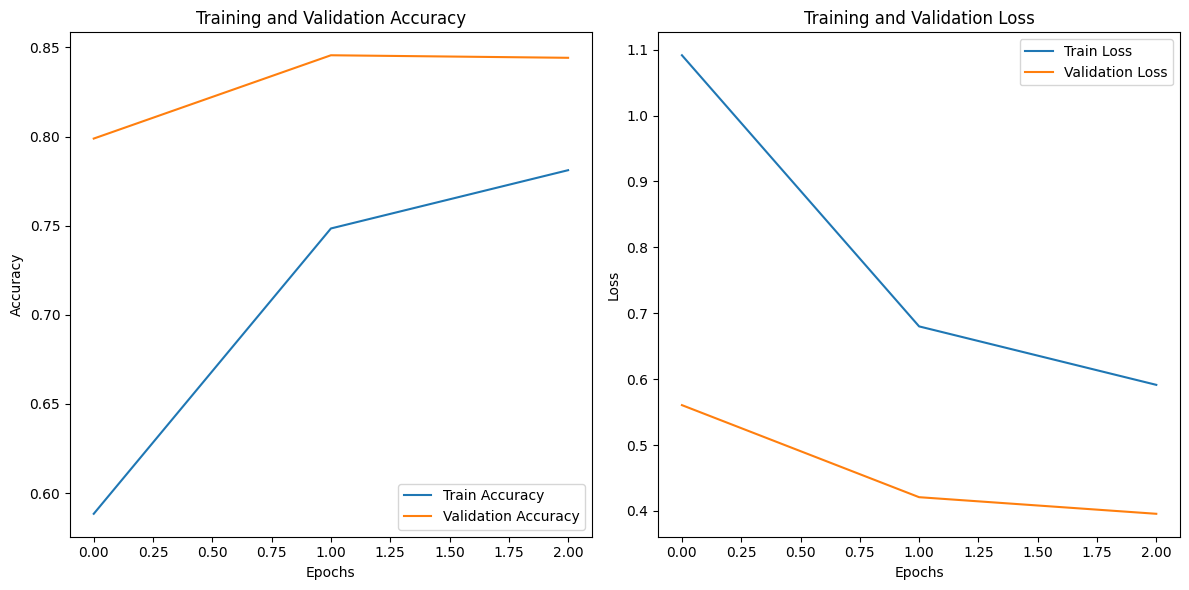

In [55]:
# Visualisasi Akurasi dan Loss
import matplotlib.pyplot as plt

# Plot akurasi training dan validation
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


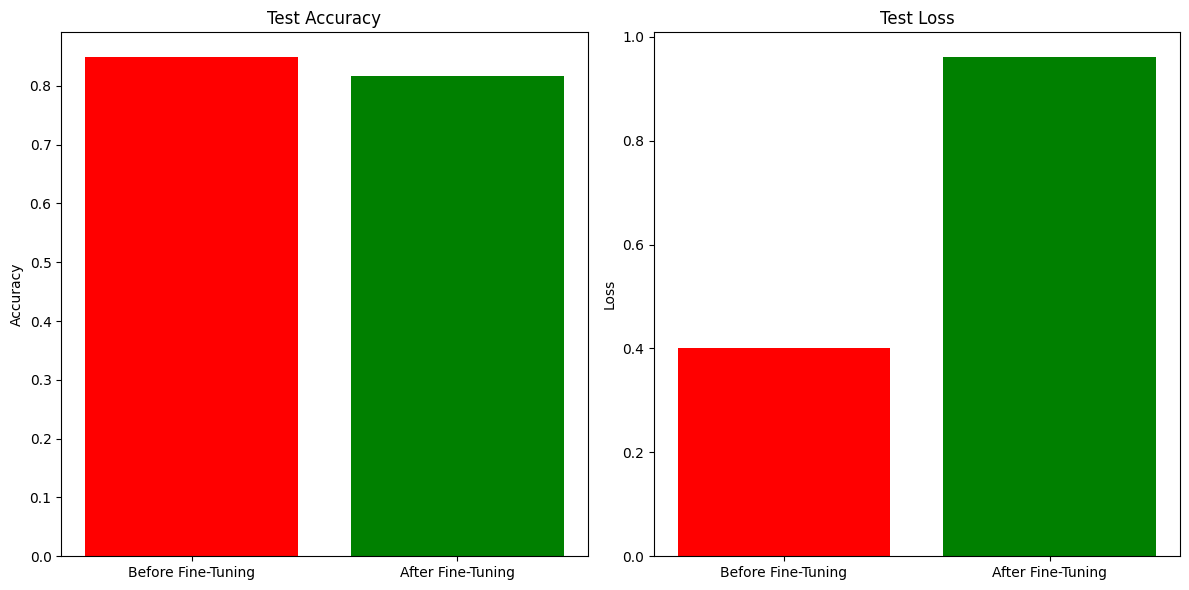

In [56]:
# Visualisasi Hasil Evaluasi Test Set setelah Fine-Tuning
test_accuracies = [test_accuracy, 0.8173]  # Akurasi sebelumnya dan setelah fine-tuning
test_losses = [test_loss, 0.9606]  # Loss sebelumnya dan setelah fine-tuning

# Membuat plot
labels = ['Before Fine-Tuning', 'After Fine-Tuning']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot untuk akurasi
ax1.bar(labels, test_accuracies, color=['red', 'green'])
ax1.set_title('Test Accuracy')
ax1.set_ylabel('Accuracy')

# Bar plot untuk loss
ax2.bar(labels, test_losses, color=['red', 'green'])
ax2.set_title('Test Loss')
ax2.set_ylabel('Loss')

plt.tight_layout()
plt.show()


# Fine_Tuning

In [57]:
# Unfreeze beberapa layer terakhir pada MobileNetV2
base_model.trainable = True

# Tentukan layer terakhir yang ingin diunfreeze, misalnya setelah layer ke-100
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Cek berapa layer yang di-unfreeze
print(f"Number of trainable layers: {len([layer for layer in base_model.layers if layer.trainable])}")

Number of trainable layers: 54


In [58]:
from tensorflow.keras.optimizers import Adam

# Compile model dengan learning rate kecil untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),  # Learning rate lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
# Melanjutkan training dengan model yang sudah diunfreeze
history_finetune = model.fit(
    train_generator,
    epochs=10,  # Melanjutkan dari 20 atau set 10 epoch lagi
    validation_data=valid_generator,
    callbacks=[early_stop, checkpoint, accuracy_threshold]
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6254 - loss: 1.0008
Validation accuracy 0.86 masih di bawah 0.9, percobaan ke-4

Training dihentikan karena akurasi validasi tidak melebihi 0.9 selama 3 epoch.
351/351 ━━━━━━━━━━━━━━━━━━━━ 114s 263ms/step - accuracy: 0.6256 - loss: 1.0003 - val_accuracy: 0.8559 - val_loss: 0.3834


In [60]:
# Evaluasi model menggunakan data test setelah fine-tuning
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy after Fine-tuning: {test_accuracy * 100:.2f}%')
print(f'Test Loss after Fine-tuning: {test_loss:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8760 - loss: 0.3214
Test Accuracy after Fine-tuning: 85.20%
Test Loss after Fine-tuning: 0.3911


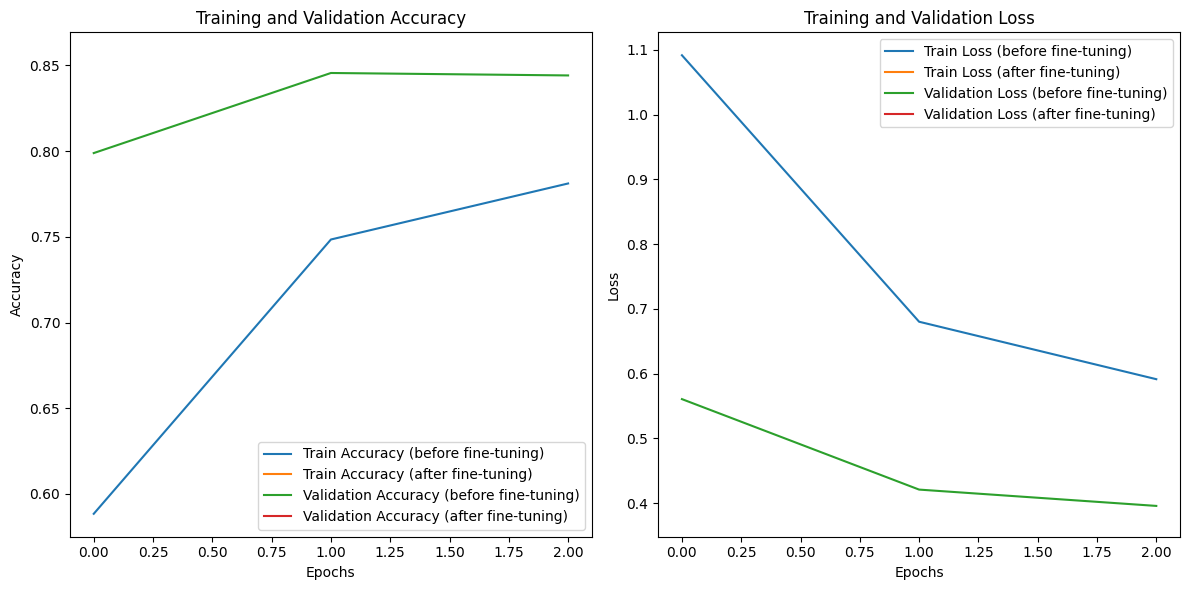

In [61]:
# Plot akurasi training dan validation setelah fine-tuning
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy (before fine-tuning)')
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy (after fine-tuning)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (before fine-tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (after fine-tuning)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (before fine-tuning)')
plt.plot(history_finetune.history['loss'], label='Train Loss (after fine-tuning)')
plt.plot(history.history['val_loss'], label='Validation Loss (before fine-tuning)')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss (after fine-tuning)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [62]:
# Konversi ke Saved_model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_249')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135590214744976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213976912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213977296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590214743632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590214744592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213979984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213980560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213980944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213980752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213976336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135590213982096

In [63]:
import tensorflow as tf

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')  # Path ke SavedModel
tflite_model = converter.convert()

# Simpan model TFLite
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan di {tflite_model_path}")

Model berhasil dikonversi dan disimpan di model.tflite


In [64]:
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Simpan label ke file 'label.txt'
labels_path = 'label.txt'
with open(labels_path, 'w') as f:
    for label in labels:
        f.write(label + '\n')

print(f"Label berhasil disimpan di {labels_path}")


Label berhasil disimpan di label.txt


In [65]:
pip install tensorflowjs

In [66]:
import tensorflowjs as tfjs

# Simpan model ke format TFJS
tfjs_model_path = 'model_tfjs'
tfjs.converters.save_keras_model(model, tfjs_model_path)

print(f"Model berhasil disimpan ke format TFJS di {tfjs_model_path}")


failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan ke format TFJS di model_tfjs


In [67]:
import zipfile
import os

# Tentukan file dan direktori yang ingin di-zip
files_to_zip = [
    'saved_model',           # Direktori SavedModel
    'model.tflite',          # Model TFLite
    'label.txt',             # Label file (jika ada)
    'model_tfjs',            # Direktori model TFJS
]

# Nama file ZIP output
zip_filename = 'models.zip'

# Membuat file ZIP
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        if os.path.isdir(file):
            # Jika itu adalah direktori, zip seluruh direktori
            for foldername, subfolders, filenames in os.walk(file):
                for filename in filenames:
                    file_path = os.path.join(foldername, filename)
                    zipf.write(file_path, os.path.relpath(file_path, start=file))
        else:
            # Jika itu adalah file tunggal, langsung ditambahkan
            zipf.write(file, os.path.basename(file))

print(f"Model dan file lainnya telah berhasil di-zip menjadi {zip_filename}")


Model dan file lainnya telah berhasil di-zip menjadi models.zip


#Predict

In [68]:
print(os.listdir('/kaggle/input/intel-image-classification/'))


['seg_train', 'seg_pred', 'seg_test']


In [69]:
print(os.listdir('/kaggle/input/intel-image-classification/seg_test/seg_test'))


['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


In [71]:
import random
from tensorflow.keras.preprocessing import image

# Menentukan folder kategori (misalnya 'mountain')
category_folder = '/kaggle/input/intel-image-classification/seg_test/seg_test/mountain'

# Menampilkan daftar gambar dalam kategori tersebut
image_files = os.listdir(category_folder)

# Memilih gambar acak dari daftar
random_image = random.choice(image_files)

# Menentukan path lengkap ke gambar yang dipilih
img_path = os.path.join(category_folder, random_image)

# Memuat gambar dan mengubah ukuran sesuai dengan input model
img = image.load_img(img_path, target_size=IMG_SIZE)

# Mengubah gambar menjadi array dan melakukan normalisasi
img_array = image.img_to_array(img) / 255.0
img_array = img_array.reshape(1, *IMG_SIZE, 3)

# Menggunakan model untuk memprediksi gambar
predictions = model.predict(img_array)

# Mendapatkan kelas dengan probabilitas tertinggi
predicted_class = predictions.argmax(axis=-1)

# Menampilkan hasil
print(f"Gambar yang diuji: {random_image}")
print(f"Prediksi Kelas: {test_generator.class_indices}")
print(f"Kelas Prediksi: {list(test_generator.class_indices.keys())[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Gambar yang diuji: 20320.jpg
Prediksi Kelas: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Kelas Prediksi: mountain


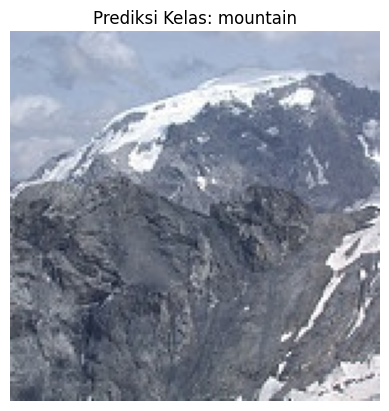

In [72]:
import matplotlib.pyplot as plt

# Menampilkan gambar yang diuji
img = image.load_img(img_path, target_size=IMG_SIZE)

plt.imshow(img)
plt.title(f"Prediksi Kelas: {list(test_generator.class_indices.keys())[predicted_class[0]]}")
plt.axis('off')  # Menonaktifkan sumbu
plt.show()


In [73]:
# Jalankan ini dalam Python (misalnya Jupyter Notebook atau script)
!pip freeze > requirements.txt
print("requirements.txt berhasil dibuat.")

requirements.txt berhasil dibuat.


In [74]:
from google.colab import files

# Ganti dengan nama file yang ingin didownload
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)